In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '2'
from quspin.operators import hamiltonian
from quspin.basis import spin_basis_1d
import numpy as np
import matplotlib.pyplot as plt
import itertools
from quspin.tools.evolution import expm_multiply_parallel
from quspin.operators import quantum_LinearOperator
from quspin.operators import quantum_operator
plt.rcParams['figure.figsize'] = [10, 8]
import matplotlib.ticker as ticker

In [7]:
def simulate(Tf, N, ein, m, Tsteps, PBC, trotter_steps=-1):

    T = Tf/m
    dt = T/Tsteps
    times = np.arange(0,T,dt)

    g = (ein**2)/(2)

    N_filled = N // 2
    E_neg1 = 0
    P_neg1 = np.exp(-1j * E_neg1)
    t = -0.5

    spin_basis = spin_basis_1d(N, pauli=-1, Nup=N_filled)
    spin_basis_m1 = spin_basis_1d(N, pauli=-1, Nup=N_filled-1)
    basis_full = spin_basis_1d(N, pauli=-1)

    ### E-field term
    def E_squared(n, g_in, E_neg1):
        E_const = (E_neg1 / max(1e-8, np.sqrt(g_in * 2))) - (n + 1) // 2
        s_coupling = []
        d_coupling = []
        for i in range(n + 1):
            s_coeff = E_const * g_in
            s_coupling += [[s_coeff, i]]
            for j in range(n + 1):
                d_coeff = 0.5 * g_in
                d_coupling += [[d_coeff, i, j]]
        return [["n", s_coupling], ["nn", d_coupling]]

    def shortest_path(n_in, m_in, N_in):
        return np.min([np.abs(n_in - m_in), N_in - np.abs(n_in - m_in)])

    def coupling(distance, N_in):
        if distance < 2:
            return distance
        elif distance == N_in // 2:
            return (N_in ** 2 - 8) / (4 * (N_in - 3))
        else:
            return distance + (distance ** 2 - 3 * distance + 2) / (3 - N_in)
    def U1spinH(g_in, t_in, m_in, N_in, N_filled_in, PBC_in, E_neg1=0, Hbasis=spin_basis, trotter=False):
        P_neg1 = np.exp(-1j * E_neg1)
        static_terms = []
        dynamic_terms = []
        
        H_list = []

        ### Hopping term
        L = (N_in if PBC else N_in - 1)
        hop_coupling = [[t_in, i, (i+1) % N_in] for i in range(N_in)]
        hop_coupling_dag = [[t_in, (i+1) % N_in, i] for i in range(N_in)]
        if PBC and N_filled % 2 == 0:
            hop_coupling[-1][0] = -hop_coupling[-1][0]
            hop_coupling_dag[-1][0] = -hop_coupling_dag[-1][0]
        if not trotter:
            static_terms += [["+-", hop_coupling]]
            static_terms += [["+-", hop_coupling_dag]]
        else:
            for c in hop_coupling:
                H_list.append(hamiltonian([["+-", [c]]], dynamic_terms, basis=Hbasis, dtype=np.float64,check_herm=False,check_pcon=False,check_symm=False))
            for c in hop_coupling_dag:
                H_list.append(hamiltonian([["+-", [c]]], dynamic_terms, basis=Hbasis, dtype=np.float64,check_herm=False,check_pcon=False,check_symm=False))

        ### Mass term
        mass_coupling = [[-m_in * (-1) ** i, i, i] for i in range(N_in)]
        if not trotter:
            static_terms += [["+-", mass_coupling]]
        else:
            for c in mass_coupling:
                H_list.append(hamiltonian([["+-", [c]]], dynamic_terms, basis=Hbasis, dtype=np.float64,check_herm=False,check_pcon=False,check_symm=False))
        

        ### E-field term
        if PBC:
            E_longrange_general = np.zeros((N_in,N_in))
            for n in range(N_in):
                for k in range(N_in):
                    E_longrange_general[n,k] = coupling(shortest_path(n, k, N_in), N_in)
            E_longrange_general = -0.25 * (N_in - 3) / (N_in - 2) * E_longrange_general

            E_longrange = [[2 * g_in * E_longrange_general[i,j],i,i,j,j] for i in range(N_in) for j in range(N_in)] # from gauss' law

            E_onsite_general = np.zeros(N_in)
            for n in range(N_in):
                for m in range(N_in):
                    if (m%2==1):
                        E_onsite_general[n] += coupling(shortest_path(n, m, N_in), N_in) + coupling(shortest_path(m, n, N_in), N_in)

            E_onsite = [[-2 * g_in * E_onsite_general[i],i,i] for i in range(N)]
            
            if not trotter:
                static_terms += [["+-+-",E_longrange],["+-",E_onsite]]
            else:
                for c in E_longrange:
                    H_list.append(hamiltonian([["+-+-", [c]]], dynamic_terms, basis=Hbasis, dtype=np.float64,check_herm=False,check_pcon=False,check_symm=False))
                for c in E_onsite:
                    H_list.append(hamiltonian([["+-", [c]]], dynamic_terms, basis=Hbasis, dtype=np.float64,check_herm=False,check_pcon=False,check_symm=False))
        else:
            for i in range(L):
                if not trotter:
                    static_terms += E_squared(i, -g_in, E_neg1)
                else:
                    E_const = (E_neg1 / max(1e-8, np.sqrt(g_in * 2))) - (i + 1) // 2
                    s_coupling = []
                    d_coupling = []
                    for k in range(i + 1):
                        s_coeff = E_const * g_in
                        s_coupling += [[s_coeff, k,k]]
                        for j in range(k + 1):
                            d_coeff = 0.5 * g_in
                            d_coupling += [[d_coeff, k,k,j,j]]
                    for c in s_coupling:
                        H_list.append(hamiltonian([["+-", [c]]], dynamic_terms, basis=Hbasis, dtype=np.float64,check_herm=False,check_pcon=False,check_symm=False))
                    for c in d_coupling:
                        H_list.append(hamiltonian([["+-+-", [c]]], dynamic_terms, basis=Hbasis, dtype=np.float64,check_herm=False,check_pcon=False,check_symm=False))

        if not trotter:
            return hamiltonian(static_terms, dynamic_terms, basis=Hbasis, dtype=np.float64)
        else:
            return H_list

    ###################################################### RTD GROUND STATE PREP #################################################


    H_init = U1spinH(g, t, m, N, N_filled, PBC)    
    E_init,V_init=H_init.eigsh(k=1,which='SA',maxiter=1e8)
    psi_i = V_init[:,0]
    psi_i = psi_i.reshape((-1,))
    del H_init

    ###################################################### RTD TIME EVOLN & LOSCHMIDT ############################################

    if trotter_steps < 1:
        H = U1spinH(g, t, -m, N, N_filled, PBC)
#         print(H.toarray())
        ##### define data type for the simulation
        dtype_real = np.float64
        dtype_cmplx = np.result_type(dtype_real,np.complex64)
        # pre assign arrays
        Lt = np.zeros(len(times),dtype=dtype_real)              # Lohschmidt echo
        # construct piece-wise constant unitaries
        expH = expm_multiply_parallel(H.tocsr(),a=-1j*dt,dtype=dtype_cmplx)
        # auxiliary array for memory efficiency
        psi=psi_i.copy().astype(np.complex128)
        work_array=np.zeros((2*len(psi),), dtype=psi.dtype) # twice as long because complex_valued
        # prepare output
        loschmidt = []
        for i in range(len(times)):
            #if i % (len(times)//10) == 0:
                #print("# T = ",times[i])
            Lt[i]=-np.log(np.abs(np.vdot(psi_i,psi)))/N
            #print(f"{times[i]}\t {Lt[i]}")
            loschmidt += [Lt[i]]
            expH.dot(psi,work_array=work_array,overwrite_v=True)
        
        # END of time evolution
    else:
        Hlist = U1spinH(g, t, -m, N, N_filled, PBC, trotter=True)
             ##### define data type for the simulation
        dtype_real = np.float64
        dtype_cmplx = np.result_type(dtype_real,np.complex64)
        # pre assign arrays
        Lt = np.zeros(len(times),dtype=dtype_real)              # Lohschmidt echo
        # auxiliary array for memory efficiency
        psi=psi_i.copy().astype(np.complex128)
        work_array=np.zeros((2*len(psi),), dtype=psi.dtype) # twice as long because complex_valued
        # prepare output
        loschmidt = []
        for i in range(len(times)):
            psi=psi_i.copy().astype(np.complex128)
            for j in range(trotter_steps):
                for h in Hlist:
                    expH = expm_multiply_parallel(h.tocsr(),a=-1j*dt*i/trotter_steps,dtype=dtype_cmplx)
                    expH.dot(psi,work_array=work_array,overwrite_v=True)
            #if i % (len(times)//10) == 0:
                #print("# T = ",times[i])
            Lt[i]=-np.log(np.abs(np.vdot(psi_i,psi)))/N
            #print(f"{times[i]}\t {Lt[i]}")
            loschmidt += [Lt[i]]
        
        # END of time evolution

    ###################################################### CORRELATOR CALCULATION #################################################

    def c_operator(n):
        cdag_static = [["z", [[-1.0, i] for i in range(n)]]] + [["-",[[1.0,n]]]]
        cdagn = quantum_LinearOperator(cdag_static,basis=basis_full,dtype=np.complex128,check_herm=False,check_pcon=False,check_symm=False)
        return(cdagn)
    annihilators = [c_operator(n) for n in range(N)]

    ##### define data type for the simulation
    dtype_real = np.float64
    dtype_cmplx = np.result_type(dtype_real,np.complex64)

    # array to store correlators expectations from psi(t,n) to psi(0,0)
    correlators = np.zeros((N,len(times)),dtype=np.complex128)

    if trotter_steps < 1:

        P_Nhalf = spin_basis.get_proj(dtype=np.float64)
        P_Nhalfminus1 = spin_basis_m1.get_proj(dtype=np.float64)

        H_NHalf_m1 = U1spinH(g, t, -m, N, N_filled, PBC, Hbasis=spin_basis_m1).tocsr()
        H_NHalf = U1spinH(g, t, -m, N, N_filled, PBC, Hbasis=spin_basis).tocsr()

        for n in range(0, N, 2): #loop over all site pairings
            for i in range(len(times)): #loop over times (for annhilator location)
                # Even Correlators
                leftPsi=psi_i.copy().astype(np.complex128) #state for left-half of inner product
                rightPsi=psi_i.copy().astype(np.complex128) #state for right-half

                expmiH = expm_multiply_parallel(H_NHalf_m1,a=1j*dt*i,dtype=dtype_cmplx)
                expiH = expm_multiply_parallel(H_NHalf,a=-1j*dt*i,dtype=dtype_cmplx)

                expiH.dot(leftPsi,overwrite_v=True)
                tempLpsi = np.transpose(P_Nhalfminus1).dot(annihilators[n].dot(P_Nhalf.dot(leftPsi)))
                expmiH.dot(tempLpsi,overwrite_v=True)

                tempRpsi = np.transpose(P_Nhalfminus1).dot(annihilators[0].dot(P_Nhalf.dot(rightPsi)))

                correlators[n,i] = np.vdot(tempLpsi, tempRpsi) # (<a|b>) <0| . e^(-iHt) . psi\dagger_n . e^(iHt) . psi(0,0) . |0>

                # Odd Correlators
                leftPsi=psi_i.copy().astype(np.complex128) #state for left-half of inner product
                rightPsi=psi_i.copy().astype(np.complex128) #state for right-half

                expiH.dot(leftPsi,overwrite_v=True) 
                tempLpsi = np.transpose(P_Nhalfminus1).dot(annihilators[n+1].dot(P_Nhalf.dot(leftPsi)))
                expmiH.dot(tempLpsi,overwrite_v=True)

                tempRpsi = np.transpose(P_Nhalfminus1).dot(annihilators[1].dot(P_Nhalf.dot(rightPsi)))

                correlators[n+1,i] = np.vdot(tempLpsi, tempRpsi) # (<a|b>) <0| . e^(-iHt) . psi\dagger_n . e^(iHt) . psi(0,0) . |0>

    else:

        P_Nhalf = spin_basis.get_proj(dtype=np.float64)
        P_Nhalfminus1 = spin_basis_m1.get_proj(dtype=np.float64)

        H_NHalf_m1_s = U1spinH(g, t, -m, N, N_filled, PBC, Hbasis=spin_basis_m1, trotter=True)
        H_NHalf_s = U1spinH(g, t, -m, N, N_filled, PBC, Hbasis=spin_basis, trotter=True)

        for n in range(0, N, 2): #loop over all site pairings
            for i in range(len(times)): #loop over times (for annhilator location)
                # Even Correlators
                leftPsi=psi_i.copy().astype(np.complex128) #state for left-half of inner product
                rightPsi=psi_i.copy().astype(np.complex128) #state for right-half

                t_dt = dt * i / trotter_steps
                for t_step in range(trotter_steps):
                    for h in range(len(H_NHalf_m1_s)):
                        expiH = expm_multiply_parallel(H_NHalf_s[h].tocsr(),a=-1j*t_dt,dtype=dtype_cmplx)
                        expiH.dot(leftPsi,overwrite_v=True)
                    
                tempLpsi = np.transpose(P_Nhalfminus1).dot(annihilators[n].dot(P_Nhalf.dot(leftPsi)))
                
                t_dt = dt * i / trotter_steps
                for t_step in range(trotter_steps):
                    for h in range(len(H_NHalf_m1_s)):
                        expmiH = expm_multiply_parallel(H_NHalf_m1_s[h].tocsr(),a=1j*t_dt,dtype=dtype_cmplx)
                        expmiH.dot(tempLpsi,overwrite_v=True)

                tempRpsi = np.transpose(P_Nhalfminus1).dot(annihilators[0].dot(P_Nhalf.dot(rightPsi)))

                correlators[n,i] = np.vdot(tempLpsi, tempRpsi) # (<a|b>) <0| . e^(-iHt) . psi\dagger_n . e^(iHt) . psi(0,0) . |0>

                # Odd Correlators
                leftPsi=psi_i.copy().astype(np.complex128) #state for left-half of inner product
                rightPsi=psi_i.copy().astype(np.complex128) #state for right-half

                
                t_dt = dt * i / trotter_steps
                for t_step in range(trotter_steps):
                    for h in range(len(H_NHalf_m1_s)):
                        expiH = expm_multiply_parallel(H_NHalf_s[h].tocsr(),a=-1j*t_dt,dtype=dtype_cmplx)
                        expiH.dot(leftPsi,overwrite_v=True)
                    
                tempLpsi = np.transpose(P_Nhalfminus1).dot(annihilators[n+1].dot(P_Nhalf.dot(leftPsi)))
                
                t_dt = dt * i / trotter_steps
                for t_step in range(trotter_steps):
                    for h in range(len(H_NHalf_m1_s)):
                        expmiH = expm_multiply_parallel(H_NHalf_m1_s[h].tocsr(),a=1j*t_dt,dtype=dtype_cmplx)
                        expmiH.dot(tempLpsi,overwrite_v=True)

                tempRpsi = np.transpose(P_Nhalfminus1).dot(annihilators[1].dot(P_Nhalf.dot(rightPsi)))

                correlators[n+1,i] = np.vdot(tempLpsi, tempRpsi) # (<a|b>) <0| . e^(-iHt) . psi\dagger_n . e^(iHt) . psi(0,0) . |0>


    correlatorfft = []
    for i in range(len(correlators[0, :])):
        fftsum = np.fft.fft(correlators[::2,i]) + np.fft.fft(correlators[1::2,i])
        correlatorfft.append(fftsum)
        
    correlatorfft = np.array(correlatorfft)

    ###################################################### NU CALCULATION ##########################################################

    t_slices, k_modes = np.shape(correlatorfft)
    dphi_k = np.zeros((t_slices-1, k_modes))
    dphi_t = np.zeros((t_slices-1, k_modes))
    for t in range(t_slices-1):
        for k in range(k_modes):
            dphi_k[t, k] = np.angle(correlatorfft[t, (k+1)%k_modes]/correlatorfft[t, k])
            dphi_t[t, k] = np.angle(correlatorfft[t + 1, k]/correlatorfft[t, k])
            
    finite_full = np.zeros((t_slices - 2, k_modes))
    for t in range(t_slices-2):
        for k in range(k_modes):
            finite_full[t, k] = (dphi_k[t, k] + dphi_t[t, (k+1)%k_modes]) - (dphi_k[t+1, k] + dphi_t[t, k])
    finite_left = np.zeros(t_slices-2)
    finite_right = np.zeros(t_slices-2)
    for k in range(k_modes//2):
        finite_left += finite_full[:,k]/2/np.pi
        finite_right += finite_full[:,k+k_modes//2]/2/np.pi
    n_left = []
    n_right = []
    for t in range(t_slices-2):
        ntau_left = 0
        ntau_right = 0
        for tau in range(0,t):
            ntau_left += finite_left[tau]
            ntau_right += finite_right[tau]
        n_left.append(ntau_left)
        n_right.append(ntau_right)
    n_left = np.array(n_left)
    n_right = np.array(n_right)

    return((-n_left+n_right, loschmidt))

In [8]:
Ninput = 4

minput = .8

PBCinput = True
tsteps_input = -1

Tf = 2
timesteps = 40
esteps = 40

einit = 0
ef = 2*minput
de = ef/esteps
evals = [de*i for i in range(esteps)]

titleinfo = ("N={:.0f}, m={:.1f}, Periodic, Dim=({:},{:}), Trotters={:} ".format(Ninput,minput,timesteps,esteps,tsteps_input) if PBCinput
             else "N={:.0f}, m={:.1f}, Fixed, Dim=({:},{:}), Trotters={:} ".format(Ninput,minput,timesteps,esteps,tsteps_input))

In [9]:
Loschmidts = np.zeros((timesteps,esteps))
nuvals = np.zeros((timesteps-2,esteps))
for k in range(esteps):
    tempvecNu,tempvecL = simulate(Tf,Ninput,evals[k],minput,timesteps,PBCinput,trotter_steps=tsteps_input)
    tempvecL = np.flip(tempvecL)
    tempvecNu = np.flip(tempvecNu)
    Loschmidts[:,k] = tempvecL
    nuvals[:,k] = tempvecNu
    print("--------------------------------------------------------------------------------------------------------")
    print("Done with " + str(k+1) +" of " + str(esteps) + " (" + str(round((k+1)/esteps*100,2)) + "%)")
    print("--------------------------------------------------------------------------------------------------------")


Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
[ 0.        +0.j -0.21659437+0.j -0.90130324+0.j -0.21659437+0.j]
[ 0.        +0.j         -0.21757802-0.02811459j -0.89639679+0.06285138j
 -0.21757802-0.02811459j]
[ 0.        +0.j         -0.22050982-0.05592336j -0.88175788+0.12447904j
 -0.22050982-0.05592336j]
[ 0.        +0.j         -0.22533266-0.08312552j -0.85762637+0.18368006j
 -0.22533266-0.08312552j]
[ 0.        +0.j         -0.23195243-0.1094302j  -0.82439758+0.23929281j
 -0.23195243-0.1094302j ]
[ 0.        +0.j         -0.24023959-0.13456123j -0.78261557+0.29021669j
 -0.24023959-0.13456123j]
[ 0.        +0.j         -0.25003146-0.15826165j -0.73296401+0.33543083j
 -0.25003146-0.1582616

[ 0.        +0.j          0.40023265+0.25228081j -0.29833113+0.12518542j
  0.40023265+0.25228081j]
[ 0.        +0.j          0.39486676+0.24303452j -0.31291658+0.20528293j
  0.39486676+0.24303452j]
[ 0.        +0.j          0.38699981+0.23346962j -0.31836337+0.285547j
  0.38699981+0.23346962j]
[ 0.        +0.j          0.37664582+0.2238697j  -0.31469334+0.36475917j
  0.37664582+0.2238697j ]
[ 0.        +0.j          0.36385643+0.21451525j -0.3020839 +0.441715j
  0.36385643+0.21451525j]
[ 0.        +0.j          0.34872025+0.2056789j  -0.28086499+0.51524398j
  0.34872025+0.2056789j ]
[ 0.        +0.j          0.33136145+0.19762073j -0.25151345+0.584229j
  0.33136145+0.19762073j]
[ 0.        +0.j          0.31193784+0.19058384j -0.21464496+0.64762481j
  0.31193784+0.19058384j]
[ 0.        +0.j          0.29063831+0.18479019j -0.17100368+0.70447538j
  0.29063831+0.18479019j]
[ 0.        +0.j          0.26767991+0.18043683j -0.12144967+0.75392973j
  0.26767991+0.18043683j]
[ 0.        +0.j

[ 0.31623263-0.49383986j -0.33364957-0.22958167j  0.        +0.j
  0.33364957+0.22958167j]
[ 0.29326558-0.56399025j -0.31636611-0.22111097j  0.        +0.j
  0.31636611+0.22111097j]
[ 0.2627371 -0.62925949j -0.29699086-0.21341709j  0.        +0.j
  0.29699086+0.21341709j]
[ 0.22527643-0.6886951j  -0.27568854-0.20672017j  0.        +0.j
  0.27568854+0.20672017j]
[ 0.18162689-0.74143333j -0.25265155-0.20121945j  0.        +0.j
  0.25265155+0.20121945j]
[ 0.13263384-0.78671289j -0.22809713-0.19709001j  0.        +0.j
  0.22809713+0.19709001j]
[ 0.07923094-0.82388709j -0.202264  -0.19447983j  0.        +0.j
  0.202264  +0.19447983j]
[ 0.02242503-0.85243406j -0.17540873-0.19350736j  0.        +0.j
  0.17540873+0.19350736j]
[-0.03672012-0.87196509j -0.14780179-0.19425952j  0.        +0.j
  0.14780179+0.19425952j]
[-0.09710109-0.88223071j -0.11972341-0.19679022j  0.        +0.j
  0.11972341+0.19679022j]
[-0.15759262-0.8831247j  -0.09145925-0.20111946j  0.        +0.j
  0.09145925+0.20111946j]

[ 0.        +0.j         -0.30393313-0.34624892j -0.17084692+0.3489365j
 -0.30393313-0.34624892j]
[ 0.        +0.j         -0.30981016-0.35449782j -0.09798482+0.322172j
 -0.30981016-0.35449782j]
[ 0.        +0.j         -0.31464784-0.36056529j -0.02684086+0.28850857j
 -0.31464784-0.36056529j]
[ 0.        +0.j         -0.3182639 -0.36450349j  0.04173266+0.24827312j
 -0.3182639 -0.36450349j]
[ 0.        +0.j         -0.32048695-0.36638829j  0.10692379+0.20188671j
 -0.32048695-0.36638829j]
[ 0.        +0.j         -0.32115899-0.36631797j  0.16797172+0.14985899j
 -0.32115899-0.36631797j]
[ 0.        +0.j         -0.3201378 -0.36441167j  0.22417689+0.09278157j
 -0.3201378 -0.36441167j]
[ 0.        +0.j         -0.31729915-0.36080757j  0.2749102 +0.03132019j
 -0.31729915-0.36080757j]
[ 0.        +0.j         -0.31253871-0.35566078j  0.31962135-0.03379408j
 -0.31253871-0.35566078j]
[ 0.        +0.j         -0.30577375-0.34914104j  0.35784597-0.1017746j
 -0.30577375-0.34914104j]
[ 0.        +0

[ 0.28306309-0.34058593j  0.26020073+0.36505439j  0.        +0.j
 -0.26020073-0.36505439j]
[ 0.21025081-0.32730786j  0.26298419+0.37816049j  0.        +0.j
 -0.26298419-0.37816049j]
[ 0.13722383-0.3079803j   0.26501065+0.38903573j  0.        +0.j
 -0.26501065-0.38903573j]
[ 0.06473428-0.2827195j   0.26613883+0.39766809j  0.        +0.j
 -0.26613883-0.39766809j]
[-0.00647763-0.25171792j  0.26623235+0.40406605j  0.        +0.j
 -0.26623235-0.40406605j]
[-0.07569211-0.21524217j  0.2651616 +0.40825813j  0.        +0.j
 -0.2651616 -0.40825813j]
[-0.14221798-0.17363018j  0.26280565+0.41029239j  0.        +0.j
 -0.26280565-0.41029239j]
[-0.20540056-0.1272874j   0.259054  +0.41023549j  0.        +0.j
 -0.259054  -0.41023549j]
[-0.26462904-0.0766822j   0.25380828+0.40817176j  0.        +0.j
 -0.25380828-0.40817176j]
[-0.31934338-0.0223406j   0.24698373+0.40420195j  0.        +0.j
 -0.24698373-0.40420195j]
[-0.3690406 +0.03515984j  0.23851063+0.39844182j  0.        +0.j
 -0.23851063-0.39844182j]

[ 0.        +0.j -0.21525337+0.j -0.90258736+0.j -0.21525337+0.j]
[ 0.        +0.j         -0.21490989-0.036871j   -0.89953091+0.02571415j
 -0.21490989-0.036871j  ]
[ 0.        +0.j         -0.21387961-0.07352343j -0.89038314+0.0511579j
 -0.21387961-0.07352343j]
[ 0.        +0.j         -0.21216315-0.10974007j -0.87520857+0.0760633j
 -0.21216315-0.10974007j]
[ 0.        +0.j         -0.2097615 -0.14530644j -0.85411423+0.10016733j
 -0.2097615 -0.14530644j]
[ 0.        +0.j         -0.20667617-0.18001209j -0.82724887+0.12321427j
 -0.20667617-0.18001209j]
[ 0.        +0.j         -0.2029092 -0.21365192j -0.79480187+0.14495805j
 -0.2029092 -0.21365192j]
[ 0.        +0.j         -0.19846331-0.24602749j -0.75700188+0.1651645j
 -0.19846331-0.24602749j]
[ 0.        +0.j         -0.19334196-0.2769482j  -0.71411513+0.18361353j
 -0.19334196-0.2769482j ]
[ 0.        +0.j         -0.18754951-0.30623248j -0.66644349+0.20010112j
 -0.18754951-0.30623248j]
[ 0.        +0.j         -0.18109137-0.3337089

  0.18595608+0.22806519j]
[-0.76928414+0.09738532j -0.17584231-0.26221934j  0.        +0.j
  0.17584231+0.26221934j]
[-0.72972448+0.11030289j -0.16437918-0.29464105j  0.        +0.j
  0.16437918+0.29464105j]
[-0.68565138+0.12282545j -0.15165229-0.32511629j  0.        +0.j
  0.15165229+0.32511629j]
[-0.63733996+0.13490549j -0.13775669-0.35344401j  0.        +0.j
  0.13775669+0.35344401j]
[-0.58509173+0.14649621j -0.1227962 -0.37943738j  0.        +0.j
  0.1227962 +0.37943738j]
[-0.52923272+0.15755164j -0.10688265-0.40292512j  0.        +0.j
  0.10688265+0.40292512j]
[-0.47011143+0.16802674j -0.09013507-0.42375256j  0.        +0.j
  0.09013507+0.42375256j]
[-0.40809661+0.17787758j -0.07267879-0.44178272j  0.        +0.j
  0.07267879+0.44178272j]
[-0.34357496+0.18706143j -0.05464454-0.45689719j  0.        +0.j
  0.05464454+0.45689719j]
[-0.27694872+0.19553694j -0.03616748-0.4689969j   0.        +0.j
  0.03616748+0.4689969j ]
[-0.20863308+0.20326428j -0.01738619-0.47800281j  0.        +0.j

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
[ 0.        +0.j -0.21386924+0.j -0.90390254+0.j -0.21386924+0.j]
[ 0.        +0.j         -0.21177273-0.04580465j -0.90113558-0.01310156j
 -0.21177273-0.04580465j]
[ 0.        +0.j         -0.20551145-0.09109153j -0.8928638 -0.02576304j
 -0.20551145-0.09109153j]
[ 0.        +0.j         -0.19516985-0.13534932j -0.87917411-0.03755052j
 -0.19516985-0.13534932j]
[ 0.        +0.j         -0.18088744-0.17807956j -0.86021018-0.04804238j
 -0.18088744-0.17807956j]
[ 0.        +0.j         -0.162857  -0.21880287j -0.83617065-0.05683522j
 -0.162857  -0.21880287j]
[ 0.        +0.j         -0.14132214-0.25706494j -0.80730672-0.06354956j
 -0.14132214-0.25706494j]
[ 0.        +0.j         -0.11657411-0.29244215j -0.77391901-0.06783524j
 -0.11657411-0.29244215j]
[ 0.        +0.j         -0.08894811-0.3245469j  -0.73635392-0.069376

 0.01709216-0.22075193j]
[0.        +0.j         0.06397314-0.2049917j  0.38871439-0.81513465j
 0.06397314-0.2049917j ]
[ 0.90443782+0.j  0.21330273+0.j  0.        +0.j -0.21330273+0.j]
[ 0.90130302+0.02911552j  0.21037658+0.04942653j  0.        +0.j
 -0.21037658-0.04942653j]
[ 0.89194837+0.05748378j  0.20164869+0.09807513j  0.        +0.j
 -0.20164869-0.09807513j]
[ 0.8765223 +0.08437044j  0.18726995+0.14518105j  0.        +0.j
 -0.18726995-0.14518105j]
[ 0.85526939+0.10906668j  0.16748893+0.19000563j  0.        +0.j
 -0.16748893-0.19000563j]
[ 0.82852623+0.13090152j  0.14264774+0.23184886j  0.        +0.j
 -0.14264774-0.23184886j]
[ 0.79671572+0.14925335j  0.11317615+0.27006116j  0.        +0.j
 -0.11317615-0.27006116j]
[ 0.76033993+0.16356072j  0.07958431+0.30405445j  0.        +0.j
 -0.07958431-0.30405445j]
[ 0.71997156+0.17333206j  0.04245408+0.333312j    0.        +0.j
 -0.04245408-0.333312j  ]
[ 0.67624428+0.17815421j  0.00242911+0.35739724j  0.        +0.j
 -0.00242911-0.357397

 -0.15808461+0.15534324j]
[ 0.84117613-0.32921053j  0.18474903-0.10898891j  0.        +0.j
 -0.18474903+0.10898891j]
--------------------------------------------------------------------------------------------------------
Done with 13 of 40 (32.5%)
--------------------------------------------------------------------------------------------------------
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
[0.        +0.j 0.21201536+0.j 0.90564781+0.j 0.21201536+0.j]
[0.        +0.j         0.20696215+0.05757405j 0.90060237+0.06574921j
 0.20696215+0.05757405j]
[0.        +0.j         0.19194902+0.113432j   0.88561066+0.12980287j
 0.19194902+0.113432j  ]
[0.        +0.j         0.16741116+0.16590739j 0.8

  0.44254739+0.19522021j]
[ 0.        +0.j          0.41188665+0.26051316j -0.13491288-0.17812259j
  0.41188665+0.26051316j]
[ 0.        +0.j          0.3698448 +0.3192676j  -0.16070893-0.13894151j
  0.3698448 +0.3192676j ]
[ 0.        +0.j          0.31786491+0.36944455j -0.19568875-0.10768656j
  0.31786491+0.36944455j]
[ 0.        +0.j          0.25775313+0.40931839j -0.2380827 -0.08604508j
  0.25775313+0.40931839j]
[ 0.        +0.j          0.19161194+0.43754054j -0.28582815-0.07533138j
  0.19161194+0.43754054j]
[ 0.        +0.j          0.12176255+0.45318926j -0.33664643-0.07643741j
  0.12176255+0.45318926j]
[ 0.        +0.j          0.05065911+0.45580356j -0.38812781-0.08979911j
  0.05065911+0.45580356j]
[ 0.        +0.j         -0.01920192+0.44540013j -0.43782139-0.1153797j
 -0.01920192+0.44540013j]
[ 0.        +0.j         -0.08537404+0.42247259j -0.48332649-0.15267041j
 -0.08537404+0.42247259j]
[ 0.        +0.j         -0.14555106+0.38797306j -0.52238217-0.20070884j
 -0.1455510

[-0.23500676-0.24686106j -0.14670886+0.44658075j  0.        +0.j
  0.14670886-0.44658075j]
[-0.26384188-0.29255425j -0.21754784+0.40481206j  0.        +0.j
  0.21754784-0.40481206j]
[-0.28196183-0.34863092j -0.27779988+0.35009389j  0.        +0.j
  0.27779988-0.35009389j]
[-0.28706913-0.41252141j -0.32500628+0.28500047j  0.        +0.j
  0.32500628-0.28500047j]
[-0.27747458-0.48120318j -0.35731904+0.21256986j  0.        +0.j
  0.35731904-0.21256986j]
[-0.25218157-0.5513424j  -0.37358596+0.13616179j  0.        +0.j
  0.37358596-0.13616179j]
[-0.21093794-0.6194504j  -0.37340333+0.05930054j  0.        +0.j
  0.37340333-0.05930054j]
[-0.15425299-0.68204763j -0.35713346-0.01448977j  0.        +0.j
  0.35713346+0.01448977j]
[-0.08337871-0.73582762j -0.32588652-0.08184987j  0.        +0.j
  0.32588652+0.08184987j]
[-2.56346177e-04-0.77781302j -2.81467272e-01-0.13974221j
  0.00000000e+00+0.j          2.81467272e-01+0.13974221j]
[ 0.09256954-0.80549661j -0.2262894 -0.18559265j  0.        +0.j
 

 0.33790661+0.2648496j ]
[0.        +0.j         0.27674748+0.34765635j 0.29807869-0.34832836j
 0.27674748+0.34765635j]
[0.        +0.j         0.19532126+0.41361628j 0.29557421-0.27517376j
 0.19532126+0.41361628j]
[0.        +0.j         0.09857577+0.45787376j 0.27636421-0.21485009j
 0.09857577+0.45787376j]
[ 0.        +0.j         -0.00741685+0.47703689j  0.24554086-0.17097622j
 -0.00741685+0.47703689j]
[ 0.        +0.j         -0.11588753+0.46942541j  0.20892766-0.14556333j
 -0.11588753+0.46942541j]
[ 0.        +0.j         -0.21984856+0.43519621j  0.17261111-0.13888442j
 -0.21984856+0.43519621j]
[ 0.        +0.j         -0.31258812+0.37633707j  0.14245532-0.14947501j
 -0.31258812+0.37633707j]
[ 0.        +0.j         -0.38814559+0.29652917j  0.12363536-0.1742645j
 -0.38814559+0.29652917j]
[ 0.        +0.j         -0.44173316+0.20088815j  0.12022368-0.20882849j
 -0.44173316+0.20088815j]
[ 0.        +0.j         -0.4700736 +0.09560244j  0.13485997-0.2477433j
 -0.4700736 +0.09560244j]

  0.00961438+0.24789638j]
[-0.44567325-0.71837372j  0.07941578-0.25499367j  0.        +0.j
 -0.07941578+0.25499367j]
[-0.28402473-0.76690592j  0.1686133 -0.2331649j   0.        +0.j
 -0.1686133 +0.2331649j ]
[-0.12182049-0.77618902j  0.24908853-0.18337801j  0.        +0.j
 -0.24908853+0.18337801j]
[ 0.03092958-0.74863257j  0.31259684-0.10923082j  0.        +0.j
 -0.31259684+0.10923082j]
[ 0.16547212-0.6892531j   0.35229264-0.01664877j  0.        +0.j
 -0.35229264+0.01664877j]
[ 0.27498777-0.60517609j  0.36336158+0.08662717j  0.        +0.j
 -0.36336158-0.08662717j]
[ 0.35509045-0.50496567j  0.34347425+0.19171736j  0.        +0.j
 -0.34347425-0.19171736j]
[ 0.40410644-0.39784216j  0.29302059+0.28938527j  0.        +0.j
 -0.29302059-0.28938527j]
[ 0.42311078-0.29285744j  0.21510363+0.37085493j  0.        +0.j
 -0.21510363-0.37085493j]
[ 0.41571997-0.19810144j  0.11529262+0.42859164j  0.        +0.j
 -0.11529262-0.42859164j]
[ 0.38766186-0.12000979j  0.00115675+0.45697664j  0.        +0.j

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
[0.        +0.j 0.20596483+0.j 0.91121564+0.j 0.20596483+0.j]
[0.        +0.j         0.18646917+0.09392248j 0.87615264+0.24080656j
 0.18646917+0.09392248j]
[0.        +0.j         0.13077432+0.17313163j 0.77447452+0.46030782j
 0.13077432+0.17313163j]
[0.        +0.j        0.04688328+0.2249308j 0.61630333+0.6395331j
 0.04688328+0.2249308j]
[ 0.        +0.j         -0.05306124+0.24039057j  0.41719205+0.76389678j
 -0.05306124+0.24039057j]
[ 0.        +0.j         -0.15440552+0.21560174j  0.19632185+0.82471633j
 -0.15440552+0.21560174j]
[ 0.        +0.j         -0.24195763+0.15226418j -0.02569868+0.82001713j
 -0.24195763+0.15226418j]
[ 0.        +0.j         -0.30204522+0.05753169j -0.22915911+0.75453381j
 -0.30204522+0.05753169j]
[ 0

[ 0.        +0.j          0.04323135-0.48821486j -0.05323479+0.19046063j
  0.04323135-0.48821486j]
[ 0.        +0.j          0.20861751-0.44344561j -0.04652766+0.1928058j
  0.20861751-0.44344561j]
[ 0.        +0.j          0.34683513-0.34276656j -0.05251165+0.21472872j
  0.34683513-0.34276656j]
[ 0.        +0.j          0.439397  -0.20015916j -0.08155256+0.24660804j
  0.439397  -0.20015916j]
[ 0.        +0.j          0.47441326-0.03544369j -0.13861973+0.27475043j
  0.47441326-0.03544369j]
[ 0.        +0.j          0.44828923+0.12865699j -0.2219622 +0.28402354j
  0.44828923+0.12865699j]
[ 0.        +0.j          0.36617495+0.26987266j -0.3229649 +0.26083001j
  0.36617495+0.26987266j]
[ 0.        +0.j          0.24110311+0.36964987j -0.42723116+0.19592496j
  0.24110311+0.36964987j]
[ 0.        +0.j          0.09195257+0.41583058j -0.51673902+0.08659916j
  0.09195257+0.41583058j]
[ 0.        +0.j         -0.05944603+0.40434169j -0.5727414 -0.06215423j
 -0.05944603+0.40434169j]
[ 0.       

 -0.44104827-0.01712393j]
[ 0.07551772-0.40793676j  0.41311007+0.19055507j  0.        +0.j
 -0.41311007-0.19055507j]
[ 0.15621096-0.3243916j   0.3170317 +0.34217388j  0.        +0.j
 -0.3170317 -0.34217388j]
[ 0.19375514-0.2381831j   0.16652622+0.44575886j  0.        +0.j
 -0.16652622-0.44575886j]
[ 0.19747897-0.16692181j -0.01499461+0.48276283j  0.        +0.j
  0.01499461-0.48276283j]
[ 0.1827838 -0.12093996j -0.19839169+0.4456811j   0.        +0.j
  0.19839169-0.4456811j ]
[ 0.16707351-0.10160747j -0.35382378+0.33948391j  0.        +0.j
  0.35382378-0.33948391j]
[ 0.16542335-0.10162704j -0.45592918+0.18084621j  0.        +0.j
  0.45592918-0.18084621j]
[ 0.18687056-0.1072119j  -0.48823581-0.00469517j  0.        +0.j
  0.48823581+0.00469517j]
[ 0.23208053-0.10168167j -0.44600909-0.1871517j   0.        +0.j
  0.44600909+0.1871517j ]
[ 0.2928689 -0.06973407j -0.33702851-0.33727292j  0.        +0.j
  0.33702851+0.33727292j]
[ 0.35369496-0.00151489j -0.18015759-0.43158735j  0.        +0.j

[0.        +0.j 0.20151412+0.j 0.91518755+0.j 0.20151412+0.j]
[0.        +0.j         0.16685858+0.11796862j 0.83442624+0.36972871j
 0.16685858+0.11796862j]
[0.        +0.j         0.07280675+0.19970611j 0.60816196+0.67037723j
 0.07280675+0.19970611j]
[ 0.        +0.j         -0.05354819+0.21894516j  0.28095768+0.84725747j
 -0.05354819+0.21894516j]
[ 0.        +0.j         -0.17519988+0.16672652j -0.08375386+0.87121431j
 -0.17519988+0.16672652j]
[ 0.        +0.j         -0.25521933+0.05417874j -0.41727685+0.74403701j
 -0.25521933+0.05417874j]
[ 0.        +0.j         -0.26686582-0.09003391j -0.66005857+0.49701994j
 -0.26686582-0.09003391j]
[ 0.        +0.j         -0.20116496-0.22698309j -0.77362626+0.18316047j
 -0.20116496-0.22698309j]
[ 0.        +0.j         -0.06993568-0.31762665j -0.74742986-0.13504755j
 -0.06993568-0.31762665j]
[ 0.        +0.j          0.09659442-0.33323292j -0.5992239 -0.39928946j
  0.09659442-0.33323292j]
[ 0.        +0.j          0.2570584 -0.26337456j -0.369

[ 0.        +0.j          0.12015583+0.22272559j -0.26358969+0.82118452j
  0.12015583+0.22272559j]
[ 0.        +0.j         -0.02435663+0.23350647j -0.61314165+0.63528202j
 -0.02435663+0.23350647j]
[ 0.        +0.j         -0.14499559+0.16467674j -0.84550057+0.30423705j
 -0.14499559+0.16467674j]
[ 0.91625378+0.j  0.20029916+0.j  0.        +0.j -0.20029916+0.j]
[ 0.81935706+0.40446948j  0.16086898+0.12403943j  0.        +0.j
 -0.16086898-0.12403943j]
[ 0.55123923+0.71933478j  0.05572614+0.20388181j  0.        +0.j
 -0.05572614-0.20388181j]
[ 0.17390775+0.87674602j -0.07979307+0.20952611j  0.        +0.j
  0.07979307-0.20952611j]
[-0.22679017+0.84668567j -0.19923953+0.13500373j  0.        +0.j
  0.19923953-0.13500373j]
[-0.5624772+0.64324989j -0.2597337+0.00080562j  0.       +0.j
  0.2597337-0.00080562j]
[-0.76362125+0.3196845j  -0.23577965-0.15191794j  0.        +0.j
  0.23577965+0.15191794j]
[-0.79541437-0.04623744j -0.12796226-0.27371551j  0.        +0.j
  0.12796226+0.27371551j]
[-0.

  0.33264941+0.07804191j]
[ 0.29811713-0.70844783j -0.21964551-0.23251412j  0.        +0.j
  0.21964551+0.23251412j]
[ 0.62653226-0.50250644j -0.04852503-0.29390725j  0.        +0.j
  0.04852503+0.29390725j]
[ 0.82029078-0.14753766j  0.1181566 -0.24975575j  0.        +0.j
 -0.1181566 +0.24975575j]
[ 0.81535304+0.27133592j  0.22335385-0.12452758j  0.        +0.j
 -0.22335385+0.12452758j]
[ 0.59985996+0.64465279j  0.2349844 +0.0304965j   0.        +0.j
 -0.2349844 -0.0304965j ]
[ 0.22074976+0.86950467j  0.15612529+0.15630959j  0.        +0.j
 -0.15612529-0.15630959j]
--------------------------------------------------------------------------------------------------------
Done with 27 of 40 (67.5%)
--------------------------------------------------------------------------------------------------------
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check p

[0.        +0.j 0.19642822+0.j 0.91959981+0.j 0.19642822+0.j]
[0.        +0.j         0.14007332+0.14174063j 0.76052042+0.51260602j
 0.14007332+0.14174063j]
[ 0.        +0.j         -0.00038401+0.20752501j  0.34150575+0.84327144j
 -0.00038401+0.20752501j]
[ 0.        +0.j         -0.15284159+0.15879865j -0.1852201 +0.87828427j
 -0.15284159+0.15879865j]
[ 0.        +0.j         -0.2364772 +0.01415389j -0.63173489+0.61353389j
 -0.2364772 +0.01415389j]
[ 0.       +0.j         -0.2013444-0.15809355j -0.8452273+0.15316087j
 -0.2013444-0.15809355j]
[ 0.        +0.j         -0.05414765-0.27142607j -0.76332997-0.33303307j
 -0.05414765-0.27142607j]
[ 0.        +0.j          0.14226735-0.26239384j -0.43284558-0.67548693j
  0.14226735-0.26239384j]
[0.        +0.j         0.29616693-0.12248393j 0.01397075-0.76742176j
 0.29616693-0.12248393j]
[0.        +0.j         0.32898632+0.09461264j 0.41420778-0.59974803j
 0.32898632+0.09461264j]
[0.        +0.j         0.21311601+0.29453742j 0.63689327-0.256

 0.30678663-0.02816217j]
[ 0.        +0.j          0.22890258+0.17168669j -0.07008647+0.81706612j
  0.22890258+0.17168669j]
[ 0.        +0.j          0.0471383 +0.26057054j -0.56191178+0.63543611j
  0.0471383 +0.26057054j]
[ 0.        +0.j         -0.1352113 +0.20402078j -0.85332782+0.17945844j
 -0.1352113 +0.20402078j]
[ 0.        +0.j        -0.22219542+0.0456882j -0.80896215-0.373828j
 -0.22219542+0.0456882j]
[ 0.92075821+0.j  0.19506686+0.j  0.        +0.j -0.19506686+0.j]
[ 0.73586304+0.54938074j  0.13217274+0.14731586j  0.        +0.j
 -0.13217274-0.14731586j]
[ 0.25904061+0.8734204j  -0.0202083 +0.20518361j  0.        +0.j
  0.0202083 -0.20518361j]
[-0.31040166+0.84361878j -0.17302812+0.1343533j   0.        +0.j
  0.17302812-0.1343533j ]
[-0.73887508+0.48175249j -0.23351432-0.03107415j  0.        +0.j
  0.23351432+0.03107415j]
[-0.85890264-0.05335359j -0.15722917-0.20034696j  0.        +0.j
  0.15722917+0.20034696j]
[-0.63774194-0.53829366j  0.02488166-0.27433956j  0.        +0.

[ 0.        +0.j          0.1607917 +0.18852492j -0.08700775+0.86420321j
  0.1607917 +0.18852492j]
[ 0.        +0.j         -0.02780829+0.22760351j -0.63147115+0.62524999j
 -0.02780829+0.22760351j]
[-0.92193508+0.j -0.19367222+0.j  0.        +0.j  0.19367222+0.j]
[-0.70844798-0.58618253j -0.12378293-0.15264554j  0.        +0.j
  0.12378293+0.15264554j]
[-0.17090597-0.89611857j  0.04026056-0.20079779j  0.        +0.j
 -0.04026056+0.20079779j]
[ 0.43347762-0.78900857j  0.18989645-0.10644245j  0.        +0.j
 -0.18989645+0.10644245j]
[ 0.82113127-0.32607166j  0.22148927+0.07614248j  0.        +0.j
 -0.22148927-0.07614248j]
[ 0.82057735+0.26450074j  0.10265074+0.23159419j  0.        +0.j
 -0.10265074-0.23159419j]
[ 0.4512608 +0.70412458j -0.10368569+0.25375647j  0.        +0.j
  0.10368569-0.25375647j]
[-0.0949677 +0.80054208j -0.27336641+0.11313348j  0.        +0.j
  0.27336641-0.11313348j]
[-0.55625566+0.53510134j -0.29449438-0.11972724j  0.        +0.j
  0.29449438+0.11972724j]
[-0.7312

[-0.11397385-0.31190624j -0.372064  +0.28982666j  0.        +0.j
  0.372064  -0.28982666j]
[ 0.12422938-0.36806866j -0.45713558-0.05744726j  0.        +0.j
  0.45713558+0.05744726j]
[ 0.37915837-0.23216163j -0.27363492-0.35455452j  0.        +0.j
  0.27363492+0.35455452j]
[ 0.49318856+0.07937156j  0.05758861-0.42930159j  0.        +0.j
 -0.05758861+0.42930159j]
[ 0.35317581+0.42507698j  0.33320754-0.25023357j  0.        +0.j
 -0.33320754+0.25023357j]
[-0.01872624+0.60314349j  0.39407847+0.06057204j  0.        +0.j
 -0.39407847-0.06057204j]
[-0.44879911+0.47221567j  0.21964313+0.30928114j  0.        +0.j
 -0.21964313-0.30928114j]
[-0.69425255+0.05455436j -0.06718695+0.35248435j  0.        +0.j
  0.06718695-0.35248435j]
[-0.5844697 -0.45044201j -0.28405918+0.1821666j   0.        +0.j
  0.28405918-0.1821666j ]
[-0.13669071-0.76359177j -0.30573417-0.07802197j  0.        +0.j
  0.30573417+0.07802197j]
[ 0.43108982-0.68531977j -0.13838382-0.25879435j  0.        +0.j
  0.13838382+0.25879435j]

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
[0.        +0.j 0.18930242+0.j 0.92555842+0.j 0.18930242+0.j]
[0.        +0.j         0.09572967+0.1666265j  0.60846099+0.69430611j
 0.09572967+0.1666265j ]
[ 0.        +0.j         -0.09913832+0.17423202j -0.12010976+0.90820308j
 -0.09913832+0.17423202j]
[ 0.        +0.j         -0.2132825 +0.00692038j -0.75224003+0.50198175j
 -0.2132825 +0.00692038j]
[ 0.        +0.j         -0.13034907-0.18942608j -0.85766435-0.2300421j
 -0.13034907-0.18942608j]
[ 0.        +0.j          0.09189417-0.23150567j -0.38396095-0.77744217j
  0.09189417-0.23150567j]
[0.        +0.j         0.26279249-0.06152125j 0.32051624-0.77838957j
 0.26279249-0.06152125j]
[0.        +0.j         0.21960972+0.1919246j  0.76797324-0.26450553j
 0.21960972+0.1919246j ]


[0.        +0.j         0.3862914 -0.05339962j 0.18902907+0.59663871j
 0.3862914 -0.05339962j]
[ 0.        +0.j          0.25054911+0.27238571j -0.37436862+0.55854526j
  0.25054911+0.27238571j]
[ 0.        +0.j         -0.07833274+0.34029576j -0.71340562+0.05747639j
 -0.07833274+0.34029576j]
[ 0.        +0.j         -0.30563018+0.11780598j -0.51460079-0.55320323j
 -0.30563018+0.11780598j]
[ 0.        +0.j         -0.2491411 -0.17678367j  0.12160426-0.78225149j
 -0.2491411 -0.17678367j]
[0.        +0.j         0.01183797-0.28318275j 0.71822243-0.40351718j
 0.01183797-0.28318275j]
[0.        +0.j         0.22718142-0.13027438j 0.78666811+0.32683642j
 0.22718142-0.13027438j]
[0.        +0.j         0.21152932+0.11650015j 0.23409636+0.84376012j
 0.21152932+0.11650015j]
[ 0.92679111+0.j  0.1877886 +0.j  0.        +0.j -0.1877886 +0.j]
[ 0.56889787+0.72866553j  0.0854583 +0.17043275j  0.        +0.j
 -0.0854583 -0.17043275j]
[-0.2224546 +0.89004004j -0.11730814+0.16069994j  0.        +0.j
  

[ 0.17898206-0.01578161j -0.28414002+0.40148915j  0.        +0.j
  0.28414002-0.40148915j]
[ 0.11920402+0.0736919j  -0.49449233-0.02381834j  0.        +0.j
  0.49449233+0.02381834j]
[ 0.063423  +0.10732153j -0.24644038-0.43056015j  0.        +0.j
  0.24644038+0.43056015j]
[ 0.00632273+0.14152097j  0.22985904-0.43834664j  0.        +0.j
 -0.22985904+0.43834664j]
[-0.10354508+0.14969787j  0.48988169-0.04163131j  0.        +0.j
 -0.48988169+0.04163131j]
[-0.2293695 +0.04303629j  0.29502184+0.38645374j  0.        +0.j
 -0.29502184-0.38645374j]
[-0.2270743-0.17906578j -0.1651444+0.44924437j  0.       +0.j
  0.1651444-0.44924437j]
[-0.00335277-0.3464378j  -0.45841518+0.09923671j  0.        +0.j
  0.45841518-0.09923671j]
[ 0.3179709 -0.24864344j -0.32083709-0.3260848j   0.        +0.j
  0.32083709+0.3260848j ]
[ 0.44344879+0.12166009j  0.10171802-0.43219375j  0.        +0.j
 -0.10171802+0.43219375j]
[ 0.18218471+0.48104683j  0.40577505-0.13855423j  0.        +0.j
 -0.40577505+0.13855423j]
[-0

[ 0.50819239+0.48057926j  0.30871852-0.17996915j  0.        +0.j
 -0.30871852+0.17996915j]
[-0.15232415+0.72474657j  0.28433113+0.17899929j  0.        +0.j
 -0.28433113-0.17899929j]
[-0.73315952+0.26070623j -0.02766543+0.31282898j  0.        +0.j
  0.02766543-0.31282898j]
[-0.63052458-0.51146459j -0.27150437+0.10721968j  0.        +0.j
  0.27150437-0.10721968j]
[ 0.11311906-0.83401579j -0.19903186-0.18246028j  0.        +0.j
  0.19903186+0.18246028j]
[ 0.79498637-0.346638j    0.07441845-0.23753229j  0.        +0.j
 -0.07441845+0.23753229j]
--------------------------------------------------------------------------------------------------------
Done with 37 of 40 (92.5%)
--------------------------------------------------------------------------------------------------------
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks pas

[ 0.33696195-0.79409238j -0.11739516-0.22402424j  0.        +0.j
  0.11739516+0.22402424j]
--------------------------------------------------------------------------------------------------------
Done with 38 of 40 (95.0%)
--------------------------------------------------------------------------------------------------------
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
[ 0.        +0.j -0.1814861 +0.j -0.93179997+0.j -0.1814861 +0.j]
[ 0.        +0.j         -0.04042709-0.17988343j -0.37823069-0.84910067j
 -0.04042709-0.17988343j]
[0.        +0.j         0.1732438 -0.08440265j 0.61713131-0.68600296j
 0.1732438 -0.08440265j]
[0.        +0.j         0.13319773+0.15674233j 0.86709056+0.28091776

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
[ 0.        +0.j -0.17985603+0.j -0.93306336+0.j -0.17985603+0.j]
[ 0.        +0.j         -0.02837397-0.18052775j -0.32254979-0.87314388j
 -0.02837397-0.18052775j]
[0.        +0.j         0.1812015 -0.06068348j 0.70211939-0.60080154j
 0.1812015 -0.06068348j]
[0.        +0.j         0.09951923+0.17817635j 0.79720625+0.44481303j
 0.09951923+0.17817635j]
[ 0.        +0.j         -0.16629902+0.14506368j -0.13822814+0.88662147j
 -0.16629902+0.14506368j]
[ 0.        +0.j         -0.19453836-0.14027885j -0.85996766+0.17424785j
 -0.19453836-0.14027885j]
[ 0.        +0.j          0.09615249-0.24229646j -0.44957575-0.72530694j
  0.09615249-0.24229646j]
[0.        +0.j         0.28057387+0.03260486j 0.50619604-0.65163369j
 0.28057387+0.03260486j]
[0.        +0.j         0.04812873+0.30078683j 0.75655964+0.23761554j
 0.04812873+0.30078683j]
[ 0.        +0.j         -0.29515618+0.13998544j  0.03982475+0.75601694j

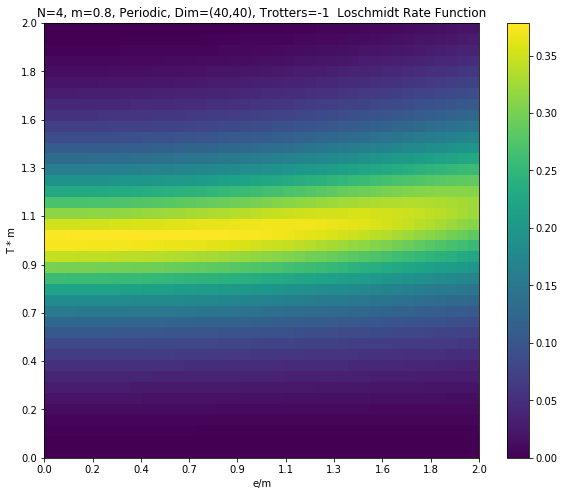

In [10]:
fig,ax = plt.subplots()
plt.ylabel("T * m")
plt.xlabel("e/m")
plt.title(titleinfo + " Loschmidt Rate Function")

im = ax.imshow(Loschmidts,aspect=esteps/timesteps)
ax.figure.colorbar(im,ax=ax)

x_tickcount=10
xticks = np.round(np.linspace(einit/minput,ef/minput,x_tickcount), 1)
ax.set_xticks(np.arange(x_tickcount))
ax.set_xticklabels(xticks)
ax.xaxis.set_major_locator(ticker.LinearLocator(x_tickcount))

y_tickcount=10
yticks=np.flip(np.round(np.linspace(0,Tf,y_tickcount), 1))
ax.set_yticks(np.arange(y_tickcount))
ax.set_yticklabels(yticks)
ax.yaxis.set_major_locator(ticker.LinearLocator(y_tickcount))

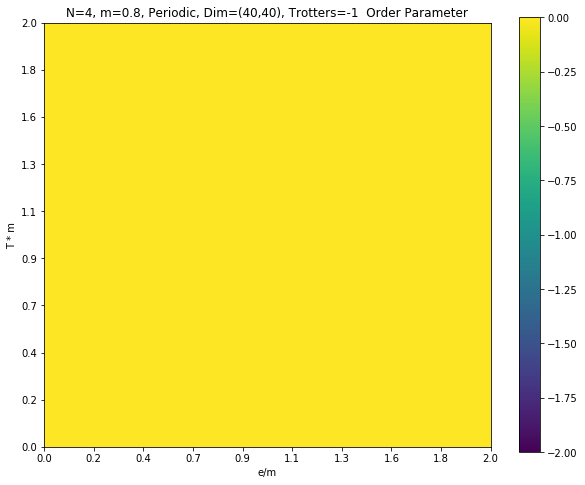

In [11]:
fig,ax = plt.subplots()
plt.ylabel("T * m")
plt.xlabel("e/m")
plt.title(titleinfo + " Order Parameter")

im = ax.imshow(nuvals,aspect=esteps/timesteps,vmin=-2)
ax.figure.colorbar(im,ax=ax)

x_tickcount=10
xticks = np.round(np.linspace(einit/minput,ef/minput,x_tickcount), 1)
ax.set_xticks(np.arange(x_tickcount))
ax.set_xticklabels(xticks)
ax.xaxis.set_major_locator(ticker.LinearLocator(x_tickcount))

y_tickcount=10
yticks=np.flip(np.round(np.linspace(0,Tf,y_tickcount), 1))
ax.set_yticks(np.arange(y_tickcount))
ax.set_yticklabels(yticks)
ax.yaxis.set_major_locator(ticker.LinearLocator(y_tickcount))
